# Step1: Initializing the main and target CNN models

In [75]:
# imports
import cv2
import math
import numpy as np
import random
# reinforcement learning related
import re
import atari_py as ap
from collections import deque
from gym import make, ObservationWrapper, Wrapper
from gym.spaces import Box
# PyTorch imports
import torch
import torch.nn as nn
from torch import save
from torch.optim import Adam
import ale_py
import gym
import matplotlib.pyplot as plt
import PIL

### define the CNN model and functions such as forward passing and taking actions
It takes input size, total number of actions as input, output probability of taking each action;
the network has 3 convolutional layers with 32, 64, 64 filters with sizes 8* 8, 4* 4, 3*3

In [34]:
class CNN(nn.Module):
    def __init__(self, input_size, num_action):
        super(CNN,self).__init__()
        self._input_size = input_size
        self._num_action = num_action
        self.convLayer = nn.Sequential(
            nn.Conv2d(self._input_size[0],32,8,4),
            nn.ReLU(),
            nn.Conv2d(32,64,4,2),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1),
            nn.ReLU()
        )
        self.linearLayer = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512,self._num_action)
        )
    def forward(self, x):
        # go through convolutional layers
        output = self.convLayer(x)
        # faltten the features
        output = output.view(x.size()[0],-1) # keep the batch dimension, and flatten the rest
        output = self.linearLayer(output)
        return output
    
    @property
    def feature_size(self):
        x = torch.zeros(1,*self._input_size)
        x = self.convLayer(x)
        return x.view(1,-1).size(1) # keep the first dimension as 1, and see what size the second
                                     #  dimension after flatten
    
    def take_action(self, state, eps, device):
        if random.random() > eps: # being greedy
            state = torch.from_numpy(np.double(state)).unsqueeze(0).to(device) # convert 
                #  state to float, increase a dimension, then sent to device where the model is
            state = state.float()
            # calculate Q values for each available action
            Q = self.forward(state)
            
            # choose an action accordingly
            #  torch.max(a,1) returns max values and their indices, we want the index
            #  representing the action with max Q value
            action = Q.max(1)[1].item()
        
        else: # select actions randomly
            action = random.randrange(self._num_action)
        return action
        
        

### define the function that instantiates the main neural network and the target neural network

In [36]:
# Add the option to load trained weights!!!!!!!!!!!!
def model_initialize(env,device,path):
    main_model = CNN(env.observation_space.shape,env.action_space.n).to(device)
    target_model = CNN(env.observation_space.shape,env.action_space.n).to(device)
    if path is not None:
        main_model.load_state_dict(torch.load(path))
        target_model.load_state_dict(torch.load(path))
        print("Weights loaded")
    #print(main_model)
    return main_model, target_model

# Step2: define the experience replay buffer
store transitions (frames) of the game to train the CNN model with random sampling

In [37]:
class ReplayBuffer:
    def __init__(self, cap_max):
        # cap_max is the defined buffer size, the number of state trasitions that stored in the buffer
        self._buffer = deque(maxlen=cap_max) # use deque to speed up the append and pop operations
    
    # append (state, action, reward, next state, finish) tuple
    def push(self, state, action, reward, next_state, finish):
        self._buffer.append((state,action,reward,next_state,finish))
    
    
    def sample(self, batch_size):
        idxs = np.random.choice(len(self._buffer),batch_size,False) # chose random samples
        # e.g. idxs = (1,5,67,51,34,97,105,...)
        
        batch = zip(*[self._buffer[i] for i in idxs]) # put corresponding frames to a zipped list
        # e.g. batch = ((state_1,action_1.reward_1,next_state_1,finish_1),
        #                (state_5,action_5,reward_5,next_state_5,finish_5, ...)
        
        state, action, reward, next_state, finish = batch # create array for each category
        # e.g. state = (state_1,state_5,state_67,...)
        #      action = (action_1, action_5, action_67, ...)
        #      ...
        return (np.array(state),np.array(action),np.array(reward,dtype=float),
                 np.array(next_state),np.array(finish,dtype=np.uint8))
    
    def __len__(self):
        return len(self._buffer)

# Step 3: setting up environment

### define some initialization-related functions

In [39]:
# replace some string with _
def gym_to_atari_format(gym_env):
    return re.sub(r"(?<!^)(?=[A-Z])", "_", gym_env).lower()

# 
def check_atari_env(env):
    for f in ["Deterministic", "ramDeterministic", "ram", "NoFrameskip", "ramNoFrameSkip"]:
        env = env.replace(f, "")
    env = re.sub(r"-v\d+", "", env)
    env = gym_to_atari_format(env) 
    return True if env in ap.list_games() else False

### augment gym environment in a series of steps, 
include 1) downsampling the video game image frames, 2) pushing iamge frames to the experience replay buffer 3) converting images into PyTorch tnesors, ... 

In [40]:
# reseting environment for both atari or non-atari environment
class CCtrl(Wrapper):
    def __init__(self,env,is_atari):
        super(CCtrl,self).__init__(env)
        self._is_atari = is_atari
        
    def reset(self):
        if self._is_atari:
            return self.env.reset()
        else:
            self.env.reset()
            return self.env.render(mode="rgb_array")

# observations (frames) will be converted to grey-scale and reshape to (84,84)
class FrmDwSmpl(ObservationWrapper):
    def __init__(self, env):
        super(FrmDwSmpl,self).__init__(env)
        self.observation_space = Box(low=0,high=255,shape=(84,84,1),dtype=np.uint8)
        self._width=84
        self._height = 84
        
    def observation(self,observation):
        frame = cv2.cvtColor(observation,cv2.COLOR_RGB2GRAY) # turn the image to gray
        frame = cv2.resize(frame,(self._width,self._height), interpolation=cv2.INTER_AREA)
        return frame[:,:,None]
    
    
# use frame-skipping technique
class MaxNSkpEnv(Wrapper):
    def __init__(self, env, atari, skip=4):
        super(MaxNSkpEnv,self).__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip
        self._atari = atari
    
    def step(self,action):
        total_reward = 0
        finish = None
        for _ in range(self._skip):
            # take a step
            obs, reward, finish, log = self.env.step(action)
            if not self._atari:
                obs = self.env.render(mode="rgb_array")
            # append the new stsate to the double ended queue buffer
            self._obs_buffer.append(obs)
            # accumulate the reward
            total_reward += reward
            if finish:
                break
        # buffer holds the last two frames, they are max-pooled, resulting in an observation
        #  that contains some temporal information
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, finish, log
    
    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs
    
    

class FrRstEnv(Wrapper):
    def __init__(self,env):
        Wrapper.__init__(self,env)
        if len(env.unwrapped.get_action_meanings()) < 3:
            raise ValueError("min requred action space of 3!")
    
    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(1)
        if finish:
            self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(2)
        if finish:
            self.env.reset(**kwargs)
        return obs
    
    def step(self, action):
        return self.env.step(action)
    

class FrmBfr(ObservationWrapper):
    def __init__(self,env,num_steps,dtype=float):
        super(FrmBfr,self).__init__(env)
        obs_space = env.observation_space
        self._dtype = dtype
        self.observation_space = Box(obs_space.low.repeat(num_steps,axis=0),
                        obs_space.high.repeat(num_steps,axis=0), dtype=self._dtype)
    
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low,dtype=self._dtype)
        return self.observation(self.env.reset())
    
    def observation(self,observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer
#
class Img2Trch(ObservationWrapper):
    def __init__(self,env):
        super(Img2Trch,self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(low=0,high=1,shape=(obs_shape[::-1]),dtype=float)
    
    def observation(self,observation):
        # move the last channel to the first place, experiment!!!!!!!
        return np.moveaxis(observation,2,0)

# normalizing pixel values
class NormFlts(ObservationWrapper):
    def observation(self,obs):
        return np.array(obs).astype(float) / 255




define a method that takes in the raw Pong video game environment as input and augments the environment, as follows:

In [44]:
def wrap_env(env_ip):
    env = gym.make(env_ip)
    is_atari = check_atari_env(env_ip) 
    env = CCtrl(env, is_atari) # preparing to reseting environment
    env = MaxNSkpEnv(env, is_atari) # initialize frame-skipping technique
    try:
        env_acts = env.unwrapped.get_action_meanings()
        if "FIRE" in env_acts:
            env = FrRstEnv(env)
    except AttributeError:
        pass
    env = FrmDwSmpl(env) # preprocessing pixels
    env = Img2Trch(env) # convert to tensor >
    env = FrmBfr(env,4) # initilize frame buffers
    env = NormFlts(env) # normalize pixel values
    return env
        

# Step 4: Defining the CNN optimization function

In [45]:
def convert(data,device):
    # data should be a numpy array
    return torch.from_numpy(data).to(device)

In [46]:
# loss function
def calc_temp_diff_loss(main_model,target_model,batch,gamma,device):
    state, action, reward, next_state, finish = batch
    
    # put tensors to cuda
    state = convert(state,device).float() 
    next_state = convert(next_state,device).float()
    action = convert(action,device)
    reward = convert(reward,device)
    finish = convert(finish,device)
    
    # use behavior policy to calculate current state action values
    Q_vals = main_model(state)
    
    # use target policy (greedy) to calculate state action values for next state
    next_Q_vals = target_model(next_state)
    
    action = action.long()
    
    # experiment!!!!!!!!!!!!!!!!!!
    Q_val = Q_vals.gather(1,action.unsqueeze(-1)).squeeze(-1)
    
    # index 0 because we wish to know the max q-value for next state, not which action that cause the max value
    next_Q_val = next_Q_vals.max(1)[0]
    
    # calculate the loss 
    expected_Q_val = reward + gamma * next_Q_val * (1-finish) 
    loss = ((Q_val - expected_Q_val.data.to(device)).pow(2)+0.1*Q_val).mean() # SSE
    
    return loss

In [47]:
# updating function: samples a batch of data from the reperiemnce replay buffer,
#  computes the time difference loss on the batch, copies the weights of the main model
#  to the target model once every TGT_UPD_FRQ iterations
def update_graph(main_model,target_model,opt,buffer,device,log,ep):
    if len(buffer) >= INIT_LEARN:
        
        if len(buffer) == INIT_LEARN:
            print("\nLearning starts!\n")
        
        # copy the wieghts main model to target model with thresholding
        if ep < 300:
            k = TGT_UPD_FRQ1
        else:
            k = TGT_UPD_FRQ2
        
        
        if log.idx % k == 0: 
            target_model.load_state_dict(main_model.state_dict())
        
        # calculate predictions (action values) loss and update the weights in the model 
        opt.zero_grad() # clear cache
        batch = buffer.sample(B_S) # B_S is hyperparameter, sample B_S tuples of (state,...)
        loss = calc_temp_diff_loss(main_model,target_model,batch,G, device)
        loss.backward()
        opt.step()

# Step5: managing and running episodes

### The updated function is implemented in sapce invaders environment

In [48]:
# define the function to update the epsillon value after each episode
# the first 3 episodes will be more exploring
# the last 100 episodes will be pure greedy
def update_eps(epd,ep):
    if ep <= 3:
        return 0.1
    elif ep >= N_EPDS - 100 - 1:
        return 0
    #if ep < 160:
        #eps_decay = EPS_DECAY1
    #else:
        #eps_decay = EPS_DECAY2
    last_eps = EPS_FINL
    first_eps = EPS_START
    eps_decay = EPS_DECAY
    eps = last_eps + (first_eps - last_eps) * math.exp(-1*((epd+1)/eps_decay))
    return eps

In [49]:
# define the function to take action after end of an episode
#  if the overall reward that's scored in the current episode is the best we've achieved so far
#  we save the CNN model weights and print the reward value
def finish_episode(main_model,env,log,ep_reward,ep,eps,done):
    best_so_far = log.update_rewards(ep_reward)
    log.update_average_rewards()
    # since final 100 episodes are pure greedy, don't save the weights when it broke
    #  best running average
    if best_so_far and (ep <= N_EPDS - 100 - 1):
        print(f"\nhighest running_average_reward of {round(log.best_average,3)} achieved!\n")
        save(main_model.state_dict(),f"Weights/{env}.pth")
    # save the weights if it is the last episode
    if done:
        save(main_model.state_dict(),f"Weights/{env}_last.pth")
    print(f"EP {ep}, curr_reward: {ep_reward}, best_reward: {log.best_reward}, running_avg_reward: {round(log.average, 3)}, curr_epsilon: {round(eps, 4)}")

In [50]:
# define the DQN loop
def run_episodes(env,main_model,target_model,buffer,device,log,ep,done):
    # initializing
    episode_reward = 0.0
    state = env.reset()
    # thresholding learning rates
    if ep < 100:
        lr = LR1
    elif ep < 300:
        lr = LR2
    elif ep < 1000:
        lr = LR3
    else:
        lr = LR4
    optimizer = Adam(main_model.parameters(),lr=lr)
    
    
    while True: 
        eps = update_eps(log.idx,ep) # update episolon based on current episode number
        action = main_model.take_action(state,eps,device) # choose an action to take
        env.render() # display the environment
        next_state, reward, finish, _ = env.step(action)  # take the action
        buffer.push(state,action,reward,next_state,finish) # push current tuple to buffer
        
        # prepare for next iteration
        state = next_state 
        episode_reward += reward
        log.update_idx()
        

        
        update_graph(main_model,target_model,optimizer,buffer,device,log,ep) # perform learning - add ep parameter
        
        # break if reached end of the episode
        if finish:
            finish_episode(main_model,ENV,log,episode_reward,ep,eps,done)
            break

# Step 6: define the matadata class

In [51]:
class TrMetadata:
    def __init__(self):
        self._average = 0.0
        self._best_reward = -float("inf")
        self._best_average = -float("inf")
        self._rewards = []
        self._average_rewards = [] # keep track of average rewards for ploting purposes
        self._average_range = 100
        self._idx = 0
        self._best_rewards = [] # keep track of best rewards for plotting purposes
    
    @property
    def best_reward(self):
        return self._best_reward
    
    @property
    def best_average(self):
        return self._best_average
    
    @property
    def average(self):
        average_range = self._average_range * -1
        average_reward = sum(self._rewards[average_range:]) / len(self._rewards[average_range:])
        return average_reward
    
    @property
    def idx(self):
        return self._idx
    
    def _update_best_reward(self,episode_reward):
        self._best_rewards.append(self._best_reward)
        if episode_reward > self.best_reward:
            self._best_reward = episode_reward
            
    
    def _update_best_average(self):
        if self.average > self.best_average:
            self._best_average = self.average
            return True
        return False
    
    def update_rewards(self,episode_reward):
        self._rewards.append(episode_reward)
        self._update_best_reward(episode_reward)
        return self._update_best_average()
    
    def update_average_rewards(self):
        self._average_rewards.append(self.average)
    
    def update_idx(self):
        self._idx += 1

# Step 7: training

In [52]:
from tqdm.auto import tqdm

def train(env,main_model,target_model,buffer,device,diff):    
    log = TrMetadata()
    progress = tqdm(range(N_EPDS))
    
    
    
    for ep in np.arange(N_EPDS):
        done = (ep == N_EPDS-1)
        
        # record how many iterations per episode every 50 episode
        if ep % 25 == 0:
            start = log.idx
            run_episodes(env,main_model,target_model,buffer,device,log,ep,done)
            print(f"\nThis episode takes {log.idx-start} iterations\n")
        else:
            run_episodes(env,main_model,target_model,buffer,device,log,ep,done)
        
        # if the difference between the current average and best average exceed diff, break
        if ((log._best_average - log.average) > diff) and (ep>=50):
            return log._average_rewards, log._rewards, log._best_rewards, ep
        
        progress.update(1)
    
    # return rewrads and average rewards
    return log._average_rewards, log._rewards, log._best_rewards, ep

In [53]:
# hypterparameters 
B_S = 64 # batch size per SGD calculation
ENV = "Pong-v4"
EPS_START = 1.0
EPS_FINL = 0.005
#EPS_DECAY = 100000
EPS_DECAY = 75000
#EPS_DECAY2 = 400000 # decaying 4 time faster - 25000, 50000, made it unstable
G = 0.99 # gamma changed from 0.99
INIT_LEARN = 4500 # initial number of iterations that are reserved for pushing data
                   #  to the buffer
LR1 = 1e-5 # changed from 1e-5
LR2 = 4e-6 # changed from 6e-6
LR3 = 6e-7 # changed from 2e-6, 1e-6
LR4 = 1e-7 # changed from 1e-6
MEM_CAP = 40000 #size of experience replay buffer

TGT_UPD_FRQ1 = 15000 # changed from 8000, 10000
TGT_UPD_FRQ2 = 30000 # changed from 16000, 20000

# Initialization - run every time

In [54]:
# start training
env = wrap_env(ENV)
device = "cuda"
path = "Weights/Pong-v4_run3_2.pth"
main_model, target_model = model_initialize(env,device,path)

buffer = ReplayBuffer(MEM_CAP)


Weights loaded


In [55]:
# create plots and save the losses
def plot_rewards(re,num_eps,reward_type,run):
    # plot and save the figure
    plt.figure(figsize=(12,8))
    x = np.arange(1,num_eps+1)
    filepath = "Figs/run_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_episode.jpg"
    plt.plot(x,re)
    plt.xlabel("Episodes")
    plt.ylabel(f"{reward_type} Reward")
    plt.title(f"{reward_type} rewards for {num_eps} episodes")
    plt.savefig(filepath)
    plt.show()
    
    # save the array
    arraypath = "Rewards/run_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_episode.npy"
    np.save(arraypath,re)
    

In [56]:
# create pretty plots
def pretty_plot(re,ave_re,best_re,run):
    plt.figure(figsize=(12,8))
    x = np.arange(1,len(re)+1)
    plt.plot(x,re,color=(0.999,0.8,0.9))
    plt.plot(x,ave_re,color=(0.9,0,0))
    plt.plot(x,best_re,color=(0,0,0.9))
    plt.legend(["Rewards", "Average Rewards", "Best Rewards"],loc="lower right")
    plt.title(f"Overview of rewards achieved in run {run}")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    filepath = "PrettyFig/run_"+str(run)+".jpg"
    plt.savefig(filepath)
    plt.show()

# Second run 1000 episodes

In [35]:
N_EPDS = 1000  # total number of episodes to train the agent for
EPS_START = 0.1
ave_re, re, best_re,ep = train(env,main_model,target_model,optimizer,buffer,device)
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))



highest running_average_reward of -12.0 achieved!

EP 0, curr_reward: -12.0, best_reward: -12.0, running_avg_reward: -12.0, curr_epsilon: 0.0991
EP 1, curr_reward: -18.0, best_reward: -12.0, running_avg_reward: -15.0, curr_epsilon: 0.0986
EP 2, curr_reward: -14.0, best_reward: -12.0, running_avg_reward: -14.667, curr_epsilon: 0.0978
EP 3, curr_reward: -8.0, best_reward: -8.0, running_avg_reward: -13.0, curr_epsilon: 0.0971
EP 4, curr_reward: -16.0, best_reward: -8.0, running_avg_reward: -13.6, curr_epsilon: 0.0965
EP 5, curr_reward: -13.0, best_reward: -8.0, running_avg_reward: -13.5, curr_epsilon: 0.0959
EP 6, curr_reward: -11.0, best_reward: -8.0, running_avg_reward: -13.143, curr_epsilon: 0.0952
EP 7, curr_reward: -18.0, best_reward: -8.0, running_avg_reward: -13.75, curr_epsilon: 0.0947
EP 8, curr_reward: -14.0, best_reward: -8.0, running_avg_reward: -13.778, curr_epsilon: 0.0941
EP 9, curr_reward: -14.0, best_reward: -8.0, running_avg_reward: -13.8, curr_epsilon: 0.0935
EP 10, cu


highest running_average_reward of -8.493 achieved!

EP 72, curr_reward: -1.0, best_reward: 3.0, running_avg_reward: -8.493, curr_epsilon: 0.0546

highest running_average_reward of -8.405 achieved!

EP 73, curr_reward: -2.0, best_reward: 3.0, running_avg_reward: -8.405, curr_epsilon: 0.0541

highest running_average_reward of -8.307 achieved!

EP 74, curr_reward: -1.0, best_reward: 3.0, running_avg_reward: -8.307, curr_epsilon: 0.0535
EP 75, curr_reward: -11.0, best_reward: 3.0, running_avg_reward: -8.342, curr_epsilon: 0.0531

highest running_average_reward of -8.26 achieved!

EP 76, curr_reward: -2.0, best_reward: 3.0, running_avg_reward: -8.26, curr_epsilon: 0.0525

highest running_average_reward of -8.179 achieved!

EP 77, curr_reward: -2.0, best_reward: 3.0, running_avg_reward: -8.179, curr_epsilon: 0.052

highest running_average_reward of -8.089 achieved!

EP 78, curr_reward: -1.0, best_reward: 3.0, running_avg_reward: -8.089, curr_epsilon: 0.0515

highest running_average_reward o


highest running_average_reward of -3.86 achieved!

EP 132, curr_reward: -9.0, best_reward: 13.0, running_avg_reward: -3.86, curr_epsilon: 0.0316

highest running_average_reward of -3.76 achieved!

EP 133, curr_reward: -1.0, best_reward: 13.0, running_avg_reward: -3.76, curr_epsilon: 0.0313
EP 134, curr_reward: -8.0, best_reward: 13.0, running_avg_reward: -3.8, curr_epsilon: 0.0311

highest running_average_reward of -3.69 achieved!

EP 135, curr_reward: -1.0, best_reward: 13.0, running_avg_reward: -3.69, curr_epsilon: 0.0308

highest running_average_reward of -3.67 achieved!

EP 136, curr_reward: -4.0, best_reward: 13.0, running_avg_reward: -3.67, curr_epsilon: 0.0306

highest running_average_reward of -3.63 achieved!

EP 137, curr_reward: -1.0, best_reward: 13.0, running_avg_reward: -3.63, curr_epsilon: 0.0303

highest running_average_reward of -3.33 achieved!

EP 138, curr_reward: 12.0, best_reward: 13.0, running_avg_reward: -3.33, curr_epsilon: 0.0301

highest running_average_reward


highest running_average_reward of 0.98 achieved!

EP 193, curr_reward: 15.0, best_reward: 17.0, running_avg_reward: 0.98, curr_epsilon: 0.0195

highest running_average_reward of 1.11 achieved!

EP 194, curr_reward: 11.0, best_reward: 17.0, running_avg_reward: 1.11, curr_epsilon: 0.0194

highest running_average_reward of 1.35 achieved!

EP 195, curr_reward: 17.0, best_reward: 17.0, running_avg_reward: 1.35, curr_epsilon: 0.0193

highest running_average_reward of 1.52 achieved!

EP 196, curr_reward: 15.0, best_reward: 17.0, running_avg_reward: 1.52, curr_epsilon: 0.0192

highest running_average_reward of 1.61 achieved!

EP 197, curr_reward: 2.0, best_reward: 17.0, running_avg_reward: 1.61, curr_epsilon: 0.019

highest running_average_reward of 1.84 achieved!

EP 198, curr_reward: 14.0, best_reward: 17.0, running_avg_reward: 1.84, curr_epsilon: 0.0189
EP 199, curr_reward: 2.0, best_reward: 17.0, running_avg_reward: 1.79, curr_epsilon: 0.0188
EP 200, curr_reward: -1.0, best_reward: 17.0, 

EP 264, curr_reward: -1.0, best_reward: 19.0, running_avg_reward: 3.45, curr_epsilon: 0.012
EP 265, curr_reward: -1.0, best_reward: 19.0, running_avg_reward: 3.31, curr_epsilon: 0.0119
EP 266, curr_reward: 6.0, best_reward: 19.0, running_avg_reward: 3.35, curr_epsilon: 0.0118
EP 267, curr_reward: -1.0, best_reward: 19.0, running_avg_reward: 3.35, curr_epsilon: 0.0117
EP 268, curr_reward: 8.0, best_reward: 19.0, running_avg_reward: 3.44, curr_epsilon: 0.0117
EP 269, curr_reward: 1.0, best_reward: 19.0, running_avg_reward: 3.35, curr_epsilon: 0.0116
EP 270, curr_reward: -1.0, best_reward: 19.0, running_avg_reward: 3.35, curr_epsilon: 0.0115
EP 271, curr_reward: -1.0, best_reward: 19.0, running_avg_reward: 3.35, curr_epsilon: 0.0115
EP 272, curr_reward: 1.0, best_reward: 19.0, running_avg_reward: 3.34, curr_epsilon: 0.0114
EP 273, curr_reward: -1.0, best_reward: 19.0, running_avg_reward: 3.32, curr_epsilon: 0.0113
EP 274, curr_reward: 8.0, best_reward: 19.0, running_avg_reward: 3.43, curr

KeyboardInterrupt: 

In [36]:
env.close()

In [39]:
# another run, modified train function
ave_re, re, best_re,ep = train(env,main_model,target_model,optimizer,buffer,device)
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]


highest running_average_reward of -14.0 achieved!

EP 0, curr_reward: -14.0, best_reward: -14.0, running_avg_reward: -14.0, curr_epsilon: 0.0992

highest running_average_reward of -12.0 achieved!

EP 1, curr_reward: -10.0, best_reward: -10.0, running_avg_reward: -12.0, curr_epsilon: 0.0985
EP 2, curr_reward: -14.0, best_reward: -10.0, running_avg_reward: -12.667, curr_epsilon: 0.0978

highest running_average_reward of -11.0 achieved!

EP 3, curr_reward: -6.0, best_reward: -6.0, running_avg_reward: -11.0, curr_epsilon: 0.097

highest running_average_reward of -9.6 achieved!

EP 4, curr_reward: -4.0, best_reward: -4.0, running_avg_reward: -9.6, curr_epsilon: 0.096
EP 5, curr_reward: -10.0, best_reward: -4.0, running_avg_reward: -9.667, curr_epsilon: 0.0953

highest running_average_reward of -8.857 achieved!

EP 6, curr_reward: -4.0, best_reward: -4.0, running_avg_reward: -8.857, curr_epsilon: 0.0945

highest running_average_reward of -8.75 achieved!

EP 7, curr_reward: -8.0, best_reward

EP 70, curr_reward: -8.0, best_reward: 13.0, running_avg_reward: -4.507, curr_epsilon: 0.052
EP 71, curr_reward: -5.0, best_reward: 13.0, running_avg_reward: -4.514, curr_epsilon: 0.0515
EP 72, curr_reward: -1.0, best_reward: 13.0, running_avg_reward: -4.466, curr_epsilon: 0.0509
EP 73, curr_reward: -2.0, best_reward: 13.0, running_avg_reward: -4.432, curr_epsilon: 0.0504

highest running_average_reward of -4.267 achieved!

EP 74, curr_reward: 8.0, best_reward: 13.0, running_avg_reward: -4.267, curr_epsilon: 0.0499
EP 75, curr_reward: -6.0, best_reward: 13.0, running_avg_reward: -4.289, curr_epsilon: 0.0494
EP 76, curr_reward: -3.0, best_reward: 13.0, running_avg_reward: -4.273, curr_epsilon: 0.049

highest running_average_reward of -4.231 achieved!

EP 77, curr_reward: -1.0, best_reward: 13.0, running_avg_reward: -4.231, curr_epsilon: 0.0485

highest running_average_reward of -4.051 achieved!

EP 78, curr_reward: 10.0, best_reward: 13.0, running_avg_reward: -4.051, curr_epsilon: 0.048

EP 132, curr_reward: -3.0, best_reward: 14.0, running_avg_reward: -1.66, curr_epsilon: 0.0293
EP 133, curr_reward: 2.0, best_reward: 14.0, running_avg_reward: -1.65, curr_epsilon: 0.029

highest running_average_reward of -1.44 achieved!

EP 134, curr_reward: 15.0, best_reward: 15.0, running_avg_reward: -1.44, curr_epsilon: 0.0289

highest running_average_reward of -1.26 achieved!

EP 135, curr_reward: 17.0, best_reward: 17.0, running_avg_reward: -1.26, curr_epsilon: 0.0287
EP 136, curr_reward: -4.0, best_reward: 17.0, running_avg_reward: -1.26, curr_epsilon: 0.0284

highest running_average_reward of -1.1 achieved!

EP 137, curr_reward: 1.0, best_reward: 17.0, running_avg_reward: -1.1, curr_epsilon: 0.0282

highest running_average_reward of -1.07 achieved!

EP 138, curr_reward: -1.0, best_reward: 17.0, running_avg_reward: -1.07, curr_epsilon: 0.0279

highest running_average_reward of -0.98 achieved!

EP 139, curr_reward: 7.0, best_reward: 17.0, running_avg_reward: -0.98, curr_epsilon: 0


highest running_average_reward of 2.42 achieved!

EP 197, curr_reward: 12.0, best_reward: 20.0, running_avg_reward: 2.42, curr_epsilon: 0.0174

highest running_average_reward of 2.47 achieved!

EP 198, curr_reward: 4.0, best_reward: 20.0, running_avg_reward: 2.47, curr_epsilon: 0.0173

highest running_average_reward of 2.62 achieved!

EP 199, curr_reward: 16.0, best_reward: 20.0, running_avg_reward: 2.62, curr_epsilon: 0.0172

highest running_average_reward of 2.63 achieved!

EP 200, curr_reward: 10.0, best_reward: 20.0, running_avg_reward: 2.63, curr_epsilon: 0.0171

highest running_average_reward of 2.87 achieved!

EP 201, curr_reward: 15.0, best_reward: 20.0, running_avg_reward: 2.87, curr_epsilon: 0.017

highest running_average_reward of 2.95 achieved!

EP 202, curr_reward: 4.0, best_reward: 20.0, running_avg_reward: 2.95, curr_epsilon: 0.0169

highest running_average_reward of 3.23 achieved!

EP 203, curr_reward: 12.0, best_reward: 20.0, running_avg_reward: 3.23, curr_epsilon: 0.

EP 268, curr_reward: 5.0, best_reward: 20.0, running_avg_reward: 5.85, curr_epsilon: 0.011

highest running_average_reward of 6.03 achieved!

EP 269, curr_reward: 17.0, best_reward: 20.0, running_avg_reward: 6.03, curr_epsilon: 0.011

highest running_average_reward of 6.23 achieved!

EP 270, curr_reward: 16.0, best_reward: 20.0, running_avg_reward: 6.23, curr_epsilon: 0.0109

highest running_average_reward of 6.36 achieved!

EP 271, curr_reward: 12.0, best_reward: 20.0, running_avg_reward: 6.36, curr_epsilon: 0.0109

highest running_average_reward of 6.42 achieved!

EP 272, curr_reward: 1.0, best_reward: 20.0, running_avg_reward: 6.42, curr_epsilon: 0.0108
EP 273, curr_reward: -1.0, best_reward: 20.0, running_avg_reward: 6.42, curr_epsilon: 0.0107
EP 274, curr_reward: -1.0, best_reward: 20.0, running_avg_reward: 6.42, curr_epsilon: 0.0107
EP 275, curr_reward: -1.0, best_reward: 20.0, running_avg_reward: 6.29, curr_epsilon: 0.0106
EP 276, curr_reward: 11.0, best_reward: 20.0, running_av


highest running_average_reward of 8.22 achieved!

EP 346, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 8.22, curr_epsilon: 0.0078

highest running_average_reward of 8.32 achieved!

EP 347, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 8.32, curr_epsilon: 0.0077
EP 348, curr_reward: -1.0, best_reward: 21.0, running_avg_reward: 8.32, curr_epsilon: 0.0077

highest running_average_reward of 8.49 achieved!

EP 349, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 8.49, curr_epsilon: 0.0077

highest running_average_reward of 8.58 achieved!

EP 350, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 8.58, curr_epsilon: 0.0077

highest running_average_reward of 8.65 achieved!

EP 351, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 8.65, curr_epsilon: 0.0076

highest running_average_reward of 8.72 achieved!

EP 352, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 8.72, curr_epsilon: 0.0076
EP 353, curr_reward: -1.0, best_reward: 21.

EP 422, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 9.91, curr_epsilon: 0.0063
EP 423, curr_reward: -2.0, best_reward: 21.0, running_avg_reward: 9.82, curr_epsilon: 0.0063
EP 424, curr_reward: 10.0, best_reward: 21.0, running_avg_reward: 9.79, curr_epsilon: 0.0063
EP 425, curr_reward: 6.0, best_reward: 21.0, running_avg_reward: 9.75, curr_epsilon: 0.0063
EP 426, curr_reward: 1.0, best_reward: 21.0, running_avg_reward: 9.68, curr_epsilon: 0.0063
EP 427, curr_reward: 11.0, best_reward: 21.0, running_avg_reward: 9.6, curr_epsilon: 0.0063
EP 428, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 9.75, curr_epsilon: 0.0062
EP 429, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 9.83, curr_epsilon: 0.0062
EP 430, curr_reward: -1.0, best_reward: 21.0, running_avg_reward: 9.68, curr_epsilon: 0.0062
EP 431, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 9.75, curr_epsilon: 0.0062
EP 432, curr_reward: 8.0, best_reward: 21.0, running_avg_reward: 9.69, cu

EP 511, curr_reward: -1.0, best_reward: 21.0, running_avg_reward: 8.84, curr_epsilon: 0.0056
EP 512, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 8.86, curr_epsilon: 0.0055
EP 513, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 8.86, curr_epsilon: 0.0055
EP 514, curr_reward: -1.0, best_reward: 21.0, running_avg_reward: 8.69, curr_epsilon: 0.0055
EP 515, curr_reward: 12.0, best_reward: 21.0, running_avg_reward: 8.68, curr_epsilon: 0.0055
EP 516, curr_reward: 9.0, best_reward: 21.0, running_avg_reward: 8.74, curr_epsilon: 0.0055
EP 517, curr_reward: 2.0, best_reward: 21.0, running_avg_reward: 8.77, curr_epsilon: 0.0055
EP 518, curr_reward: 5.0, best_reward: 21.0, running_avg_reward: 8.63, curr_epsilon: 0.0055
EP 519, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 8.77, curr_epsilon: 0.0055
EP 520, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 8.78, curr_epsilon: 0.0055
EP 521, curr_reward: 5.0, best_reward: 21.0, running_avg_reward: 8.82, cu


highest running_average_reward of 10.97 achieved!

EP 594, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 10.97, curr_epsilon: 0.0053
EP 595, curr_reward: -1.0, best_reward: 21.0, running_avg_reward: 10.97, curr_epsilon: 0.0053
EP 596, curr_reward: 7.0, best_reward: 21.0, running_avg_reward: 10.89, curr_epsilon: 0.0053
EP 597, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 10.88, curr_epsilon: 0.0053
EP 598, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 10.94, curr_epsilon: 0.0053

highest running_average_reward of 10.99 achieved!

EP 599, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 10.99, curr_epsilon: 0.0053
EP 600, curr_reward: 12.0, best_reward: 21.0, running_avg_reward: 10.91, curr_epsilon: 0.0052

highest running_average_reward of 11.0 achieved!

EP 601, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 11.0, curr_epsilon: 0.0052
EP 602, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 11.0, curr_epsilon: 0.0052

h

EP 672, curr_reward: 6.0, best_reward: 21.0, running_avg_reward: 11.07, curr_epsilon: 0.0051
EP 673, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 11.07, curr_epsilon: 0.0051
EP 674, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 10.99, curr_epsilon: 0.0051
EP 675, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 11.04, curr_epsilon: 0.0051
EP 676, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 11.06, curr_epsilon: 0.0051
EP 677, curr_reward: 15.0, best_reward: 21.0, running_avg_reward: 11.0, curr_epsilon: 0.0051
EP 678, curr_reward: 8.0, best_reward: 21.0, running_avg_reward: 11.14, curr_epsilon: 0.0051
EP 679, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 11.13, curr_epsilon: 0.0051
EP 680, curr_reward: 3.0, best_reward: 21.0, running_avg_reward: 11.27, curr_epsilon: 0.0051
EP 681, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 11.27, curr_epsilon: 0.0051
EP 682, curr_reward: 9.0, best_reward: 21.0, running_avg_reward:

EP 760, curr_reward: -2.0, best_reward: 21.0, running_avg_reward: 11.92, curr_epsilon: 0.0051
EP 761, curr_reward: 10.0, best_reward: 21.0, running_avg_reward: 11.88, curr_epsilon: 0.0051
EP 762, curr_reward: 3.0, best_reward: 21.0, running_avg_reward: 11.82, curr_epsilon: 0.0051
EP 763, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 11.89, curr_epsilon: 0.0051
EP 764, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 11.96, curr_epsilon: 0.0051
EP 765, curr_reward: 11.0, best_reward: 21.0, running_avg_reward: 11.92, curr_epsilon: 0.0051
EP 766, curr_reward: 10.0, best_reward: 21.0, running_avg_reward: 11.84, curr_epsilon: 0.0051
EP 767, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 11.81, curr_epsilon: 0.0051
EP 768, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 11.9, curr_epsilon: 0.0051
EP 769, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 12.03, curr_epsilon: 0.0051
EP 770, curr_reward: 4.0, best_reward: 21.0, running_avg_rewar

EP 848, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 10.83, curr_epsilon: 0.005
EP 849, curr_reward: 7.0, best_reward: 21.0, running_avg_reward: 10.72, curr_epsilon: 0.005
EP 850, curr_reward: -8.0, best_reward: 21.0, running_avg_reward: 10.56, curr_epsilon: 0.005
EP 851, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 10.58, curr_epsilon: 0.005
EP 852, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 10.75, curr_epsilon: 0.005
EP 853, curr_reward: 9.0, best_reward: 21.0, running_avg_reward: 10.68, curr_epsilon: 0.005
EP 854, curr_reward: 9.0, best_reward: 21.0, running_avg_reward: 10.57, curr_epsilon: 0.005
EP 855, curr_reward: 3.0, best_reward: 21.0, running_avg_reward: 10.46, curr_epsilon: 0.005
EP 856, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 10.51, curr_epsilon: 0.005
EP 857, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 10.6, curr_epsilon: 0.005
EP 858, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 10.65, cu

EP 937, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 10.71, curr_epsilon: 0.005
EP 938, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 10.76, curr_epsilon: 0.005
EP 939, curr_reward: 12.0, best_reward: 21.0, running_avg_reward: 10.85, curr_epsilon: 0.005
EP 940, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 10.96, curr_epsilon: 0.005
EP 941, curr_reward: 3.0, best_reward: 21.0, running_avg_reward: 10.8, curr_epsilon: 0.005
EP 942, curr_reward: -3.0, best_reward: 21.0, running_avg_reward: 10.62, curr_epsilon: 0.005
EP 943, curr_reward: 11.0, best_reward: 21.0, running_avg_reward: 10.54, curr_epsilon: 0.005
EP 944, curr_reward: 11.0, best_reward: 21.0, running_avg_reward: 10.45, curr_epsilon: 0.005
EP 945, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 10.38, curr_epsilon: 0.005
EP 946, curr_reward: 9.0, best_reward: 21.0, running_avg_reward: 10.39, curr_epsilon: 0.005
EP 947, curr_reward: 10.0, best_reward: 21.0, running_avg_reward: 10.4, c

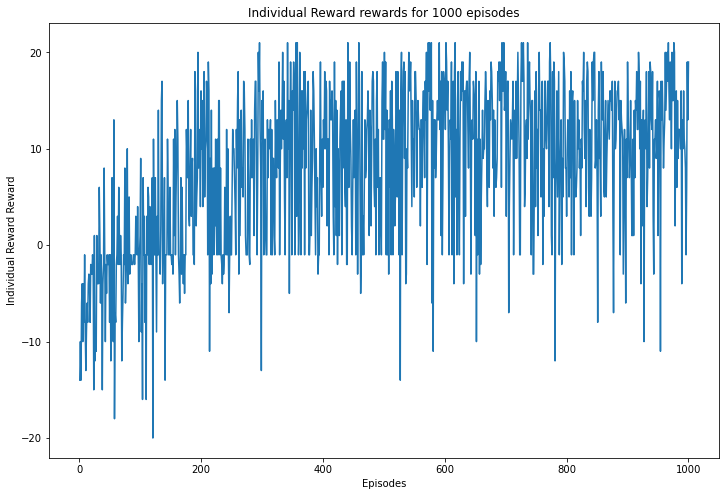

In [41]:
plot_rewards(re,1000,"Individual Reward",2)

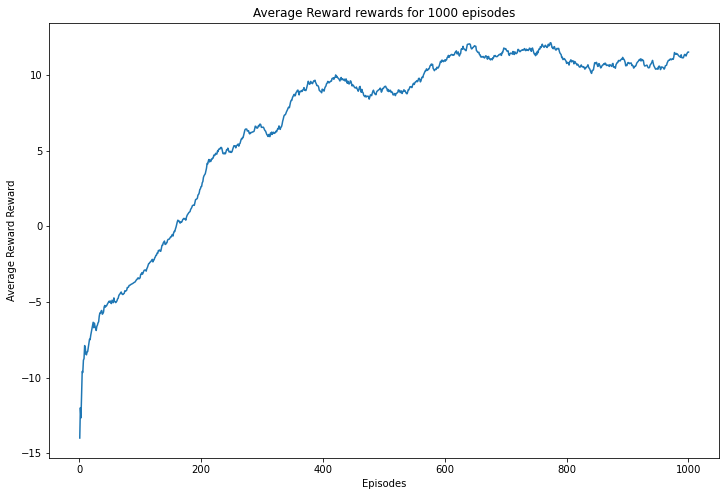

In [42]:
plot_rewards(ave_re,1000,"Average Reward",2)

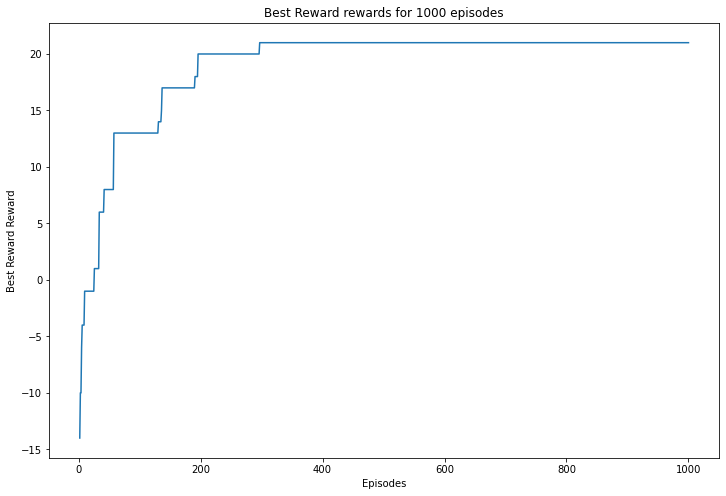

In [43]:
plot_rewards(best_re,1000,"Best Reward",2)

In [30]:
re = np.load("Rewards/run_1_Individual Reward_1500_episode.npy")
len(re)

1500

In [31]:
ave_re = np.load("Rewards/run_1_Average Reward_1500_episode.npy")
len(ave_re)

1500

In [5]:
best_re = np.load("Rewards/run_2_Best Reward_1000_episode.npy")
len(best_re)

1000

## plot run 1

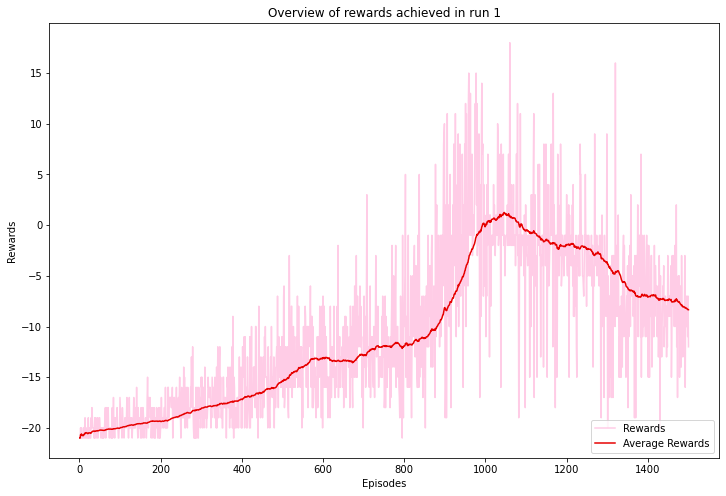

In [32]:
pretty_plot2(re,ave_re,1)

## plot run 2

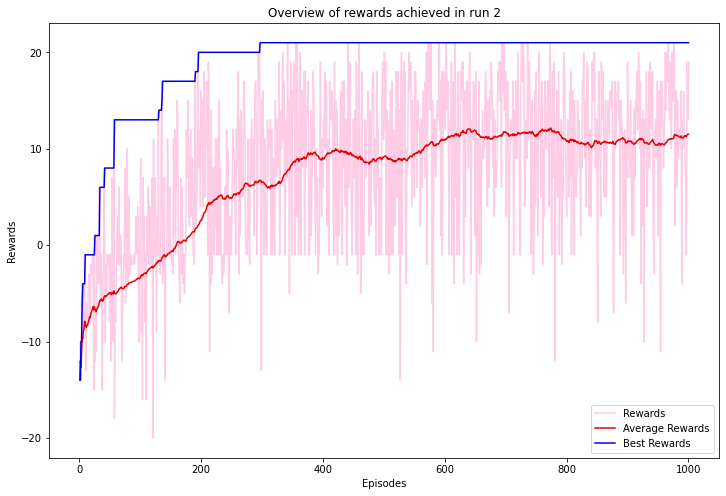

In [26]:
pretty_plot(re,ave_re,best_re,2)

# Third Run - 1000 episodes

In [24]:
EPS_START = 0.02
EPS_FINL = 0.001
N_EPDS = 1000 
ave_re, re, best_re,ep = train(env,main_model,target_model,buffer,device,diff=2.5)
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))



highest running_average_reward of -14.0 achieved!

EP 0, curr_reward: -14.0, best_reward: -14.0, running_avg_reward: -14.0, curr_epsilon: 0.1

This episode takes 849 iterations


highest running_average_reward of -11.0 achieved!

EP 1, curr_reward: -8.0, best_reward: -8.0, running_avg_reward: -11.0, curr_epsilon: 0.1

highest running_average_reward of -9.0 achieved!

EP 2, curr_reward: -5.0, best_reward: -5.0, running_avg_reward: -9.0, curr_epsilon: 0.1
EP 3, curr_reward: -15.0, best_reward: -5.0, running_avg_reward: -10.5, curr_epsilon: 0.0174

highest running_average_reward of -7.6 achieved!

EP 4, curr_reward: 4.0, best_reward: 4.0, running_avg_reward: -7.6, curr_epsilon: 0.0167

Learning starts!


highest running_average_reward of -6.667 achieved!

EP 5, curr_reward: -2.0, best_reward: 4.0, running_avg_reward: -6.667, curr_epsilon: 0.016

highest running_average_reward of -3.143 achieved!

EP 6, curr_reward: 18.0, best_reward: 18.0, running_avg_reward: -3.143, curr_epsilon: 0.0156


highest running_average_reward of 10.292 achieved!

EP 64, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 10.292, curr_epsilon: 0.0031

highest running_average_reward of 10.439 achieved!

EP 65, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 10.439, curr_epsilon: 0.0031
EP 66, curr_reward: 7.0, best_reward: 21.0, running_avg_reward: 10.388, curr_epsilon: 0.003

highest running_average_reward of 10.529 achieved!

EP 67, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 10.529, curr_epsilon: 0.003

highest running_average_reward of 10.638 achieved!

EP 68, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 10.638, curr_epsilon: 0.0029

highest running_average_reward of 10.771 achieved!

EP 69, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 10.771, curr_epsilon: 0.0029

highest running_average_reward of 10.873 achieved!

EP 70, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 10.873, curr_epsilon: 0.0028

highest running_average_re


highest running_average_reward of 15.85 achieved!

EP 122, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 15.85, curr_epsilon: 0.0014

highest running_average_reward of 16.11 achieved!

EP 123, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 16.11, curr_epsilon: 0.0014

highest running_average_reward of 16.2 achieved!

EP 124, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 16.2, curr_epsilon: 0.0014

highest running_average_reward of 16.59 achieved!

EP 125, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 16.59, curr_epsilon: 0.0014

This episode takes 560 iterations


highest running_average_reward of 16.76 achieved!

EP 126, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 16.76, curr_epsilon: 0.0014
EP 127, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 16.75, curr_epsilon: 0.0014

highest running_average_reward of 16.9 achieved!

EP 128, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 16.9, curr_epsilon: 0.001

EP 189, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 18.4, curr_epsilon: 0.0011

highest running_average_reward of 18.47 achieved!

EP 190, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.47, curr_epsilon: 0.0011

highest running_average_reward of 18.55 achieved!

EP 191, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 18.55, curr_epsilon: 0.0011
EP 192, curr_reward: 8.0, best_reward: 21.0, running_avg_reward: 18.42, curr_epsilon: 0.0011
EP 193, curr_reward: 15.0, best_reward: 21.0, running_avg_reward: 18.47, curr_epsilon: 0.0011

highest running_average_reward of 18.61 achieved!

EP 194, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.61, curr_epsilon: 0.0011
EP 195, curr_reward: -2.0, best_reward: 21.0, running_avg_reward: 18.39, curr_epsilon: 0.0011
EP 196, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.39, curr_epsilon: 0.0011
EP 197, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.42, curr_epsilon: 0.0011


EP 275, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.6, curr_epsilon: 0.001

This episode takes 550 iterations


highest running_average_reward of 18.64 achieved!

EP 276, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.64, curr_epsilon: 0.001
EP 277, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.64, curr_epsilon: 0.001

highest running_average_reward of 18.65 achieved!

EP 278, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.65, curr_epsilon: 0.001
EP 279, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 18.63, curr_epsilon: 0.001
EP 280, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 18.62, curr_epsilon: 0.001
EP 281, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 18.59, curr_epsilon: 0.001
EP 282, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.6, curr_epsilon: 0.001
EP 283, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 18.59, curr_epsilon: 0.001
EP 284, curr_reward: 21.0

EP 348, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.42, curr_epsilon: 0.001
EP 349, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.48, curr_epsilon: 0.001
EP 350, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.44, curr_epsilon: 0.001

This episode takes 755 iterations

EP 351, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.4, curr_epsilon: 0.001
EP 352, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.41, curr_epsilon: 0.001
EP 353, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.41, curr_epsilon: 0.001
EP 354, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.42, curr_epsilon: 0.001
EP 355, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.45, curr_epsilon: 0.001
EP 356, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.44, curr_epsilon: 0.001
EP 357, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 19.43, curr_epsilon: 0.001
EP 358, curr_reward: 20.0, best_rew

EP 435, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.18, curr_epsilon: 0.001
EP 436, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.15, curr_epsilon: 0.001
EP 437, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.19, curr_epsilon: 0.001
EP 438, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.18, curr_epsilon: 0.001
EP 439, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.18, curr_epsilon: 0.001
EP 440, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.2, curr_epsilon: 0.001
EP 441, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.23, curr_epsilon: 0.001
EP 442, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.23, curr_epsilon: 0.001
EP 443, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.38, curr_epsilon: 0.001
EP 444, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.43, curr_epsilon: 0.001
EP 445, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.49

EP 522, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.4, curr_epsilon: 0.001
EP 523, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.37, curr_epsilon: 0.001
EP 524, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 19.32, curr_epsilon: 0.001
EP 525, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.33, curr_epsilon: 0.001

This episode takes 555 iterations

EP 526, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.34, curr_epsilon: 0.001
EP 527, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.33, curr_epsilon: 0.001
EP 528, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.33, curr_epsilon: 0.001
EP 529, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.34, curr_epsilon: 0.001
EP 530, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.38, curr_epsilon: 0.001
EP 531, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.39, curr_epsilon: 0.001
EP 532, curr_reward: 21.0, best_rew

EP 609, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.88, curr_epsilon: 0.001
EP 610, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 18.85, curr_epsilon: 0.001
EP 611, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 18.82, curr_epsilon: 0.001
EP 612, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.82, curr_epsilon: 0.001
EP 613, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 18.79, curr_epsilon: 0.001
EP 614, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 18.79, curr_epsilon: 0.001
EP 615, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.79, curr_epsilon: 0.001
EP 616, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.82, curr_epsilon: 0.001
EP 617, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.83, curr_epsilon: 0.001
EP 618, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 18.86, curr_epsilon: 0.001
EP 619, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.8

EP 697, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 18.88, curr_epsilon: 0.001
EP 698, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 18.85, curr_epsilon: 0.001
EP 699, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 18.85, curr_epsilon: 0.001
EP 700, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.89, curr_epsilon: 0.001

This episode takes 557 iterations

EP 701, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.89, curr_epsilon: 0.001
EP 702, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.89, curr_epsilon: 0.001
EP 703, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.01, curr_epsilon: 0.001
EP 704, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.06, curr_epsilon: 0.001
EP 705, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.02, curr_epsilon: 0.001
EP 706, curr_reward: 7.0, best_reward: 21.0, running_avg_reward: 18.89, curr_epsilon: 0.001
EP 707, curr_reward: 21.0, best_rew

EP 784, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.15, curr_epsilon: 0.001
EP 785, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.15, curr_epsilon: 0.001
EP 786, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.18, curr_epsilon: 0.001
EP 787, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.18, curr_epsilon: 0.001
EP 788, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.2, curr_epsilon: 0.001
EP 789, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.21, curr_epsilon: 0.001
EP 790, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.21, curr_epsilon: 0.001
EP 791, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.18, curr_epsilon: 0.001
EP 792, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.19, curr_epsilon: 0.001
EP 793, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.18, curr_epsilon: 0.001
EP 794, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.18

EP 871, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.08, curr_epsilon: 0.001
EP 872, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.13, curr_epsilon: 0.001
EP 873, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.13, curr_epsilon: 0.001
EP 874, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.09, curr_epsilon: 0.001
EP 875, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.09, curr_epsilon: 0.001

This episode takes 573 iterations

EP 876, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.1, curr_epsilon: 0.001
EP 877, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.1, curr_epsilon: 0.001
EP 878, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 19.08, curr_epsilon: 0.001
EP 879, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.05, curr_epsilon: 0.001
EP 880, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.04, curr_epsilon: 0.001
EP 881, curr_reward: 21.0, best_rewa

EP 958, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.6, curr_epsilon: 0.001
EP 959, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.62, curr_epsilon: 0.001
EP 960, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.65, curr_epsilon: 0.001
EP 961, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.66, curr_epsilon: 0.001
EP 962, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.001
EP 963, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.001
EP 964, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.64, curr_epsilon: 0.001
EP 965, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.65, curr_epsilon: 0.001
EP 966, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.68, curr_epsilon: 0.001
EP 967, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.68, curr_epsilon: 0.001
EP 968, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.65

In [87]:
env.close()

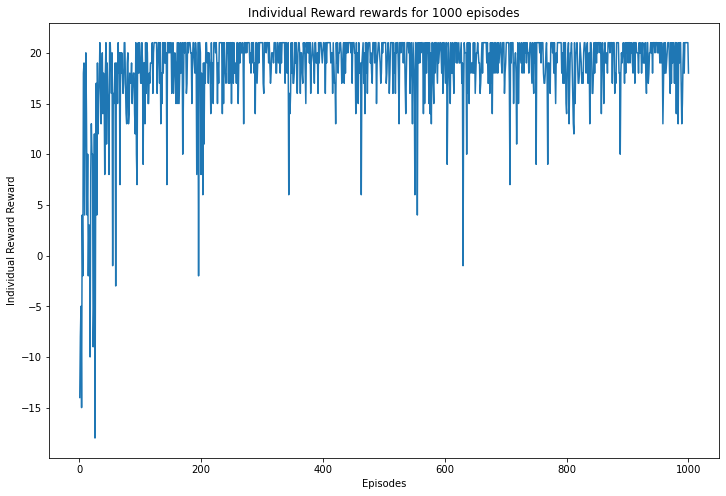

In [25]:
plot_rewards(re,1000,"Individual Reward",3)

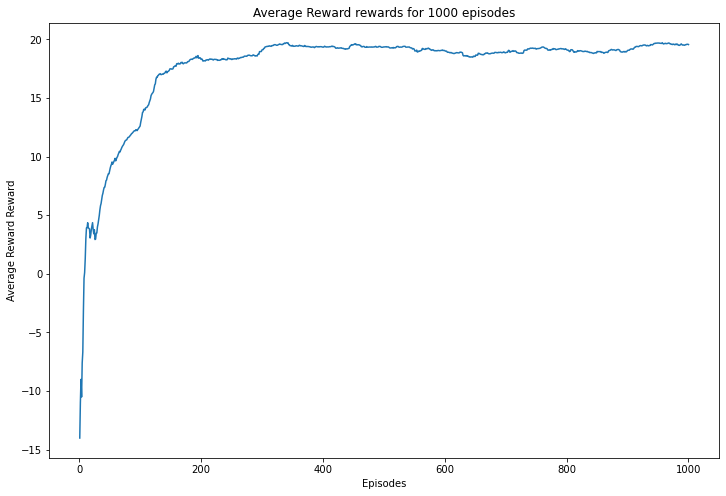

In [26]:
plot_rewards(ave_re,1000,"Average Reward",3)

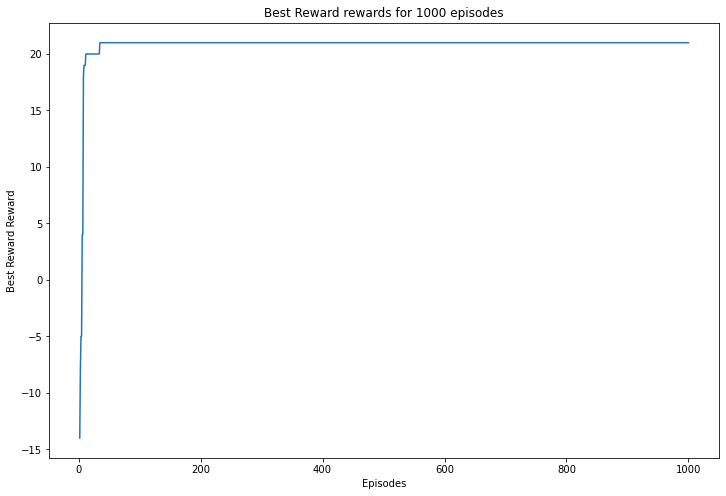

In [27]:
plot_rewards(best_re,1000,"Best Reward",3)

## plot run 3

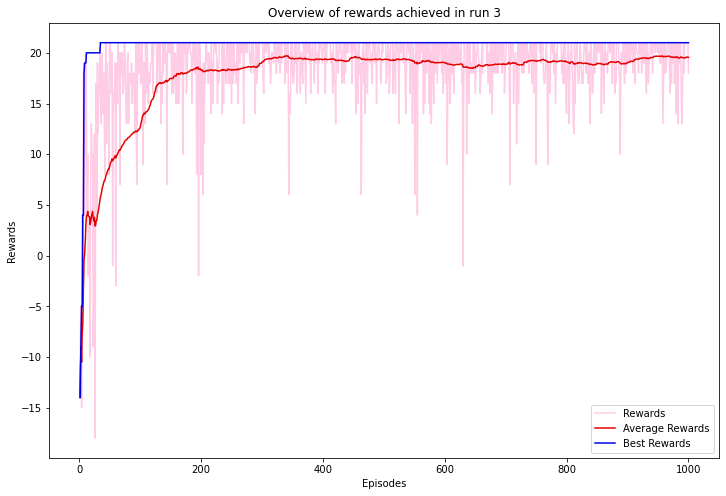

In [28]:
pretty_plot(re,ave_re,best_re,3)

# Fourth run - modified loss and adjusted degree of exploration

In [24]:
EPS_START = 0.08
EPS_FINL = 0.002 # try decay it slowly and have higher final epsilon and higher begining 
N_EPDS = 1000 
ave_re, re, best_re,ep = train(env,main_model,target_model,buffer,device,diff=2.5)
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))



highest running_average_reward of -2.0 achieved!

EP 0, curr_reward: -2.0, best_reward: -2.0, running_avg_reward: -2.0, curr_epsilon: 0.1

This episode takes 1112 iterations

EP 1, curr_reward: -15.0, best_reward: -2.0, running_avg_reward: -8.5, curr_epsilon: 0.1
EP 2, curr_reward: -5.0, best_reward: -2.0, running_avg_reward: -7.333, curr_epsilon: 0.0756
EP 3, curr_reward: -10.0, best_reward: -2.0, running_avg_reward: -8.0, curr_epsilon: 0.0742

Learning starts!

EP 4, curr_reward: -3.0, best_reward: -2.0, running_avg_reward: -7.0, curr_epsilon: 0.0725
EP 5, curr_reward: -1.0, best_reward: -1.0, running_avg_reward: -6.0, curr_epsilon: 0.071
EP 6, curr_reward: -8.0, best_reward: -1.0, running_avg_reward: -6.286, curr_epsilon: 0.0696
EP 7, curr_reward: -3.0, best_reward: -1.0, running_avg_reward: -5.875, curr_epsilon: 0.0681
EP 8, curr_reward: 16.0, best_reward: 16.0, running_avg_reward: -3.444, curr_epsilon: 0.0672
EP 9, curr_reward: -9.0, best_reward: 16.0, running_avg_reward: -4.0, c


highest running_average_reward of 3.342 achieved!

EP 72, curr_reward: 12.0, best_reward: 20.0, running_avg_reward: 3.342, curr_epsilon: 0.0205

highest running_average_reward of 3.541 achieved!

EP 73, curr_reward: 18.0, best_reward: 20.0, running_avg_reward: 3.541, curr_epsilon: 0.0202

highest running_average_reward of 3.64 achieved!

EP 74, curr_reward: 11.0, best_reward: 20.0, running_avg_reward: 3.64, curr_epsilon: 0.0199
EP 75, curr_reward: -3.0, best_reward: 20.0, running_avg_reward: 3.553, curr_epsilon: 0.0195

This episode takes 1284 iterations


highest running_average_reward of 3.714 achieved!

EP 76, curr_reward: 16.0, best_reward: 20.0, running_avg_reward: 3.714, curr_epsilon: 0.0192

highest running_average_reward of 3.846 achieved!

EP 77, curr_reward: 14.0, best_reward: 20.0, running_avg_reward: 3.846, curr_epsilon: 0.0189

highest running_average_reward of 4.0 achieved!

EP 78, curr_reward: 16.0, best_reward: 20.0, running_avg_reward: 4.0, curr_epsilon: 0.0187

highe


highest running_average_reward of 10.99 achieved!

EP 130, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 10.99, curr_epsilon: 0.0094

highest running_average_reward of 11.06 achieved!

EP 131, curr_reward: 15.0, best_reward: 21.0, running_avg_reward: 11.06, curr_epsilon: 0.0093

highest running_average_reward of 11.23 achieved!

EP 132, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 11.23, curr_epsilon: 0.0092

highest running_average_reward of 11.44 achieved!

EP 133, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 11.44, curr_epsilon: 0.0091

highest running_average_reward of 11.47 achieved!

EP 134, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 11.47, curr_epsilon: 0.009
EP 135, curr_reward: 11.0, best_reward: 21.0, running_avg_reward: 11.47, curr_epsilon: 0.0089

highest running_average_reward of 11.64 achieved!

EP 136, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 11.64, curr_epsilon: 0.0087

highest running_average_reward


highest running_average_reward of 16.81 achieved!

EP 190, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 16.81, curr_epsilon: 0.0052
EP 191, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 16.78, curr_epsilon: 0.0052

highest running_average_reward of 16.83 achieved!

EP 192, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 16.83, curr_epsilon: 0.0051

highest running_average_reward of 16.86 achieved!

EP 193, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 16.86, curr_epsilon: 0.0051
EP 194, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 16.86, curr_epsilon: 0.005

highest running_average_reward of 16.96 achieved!

EP 195, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 16.96, curr_epsilon: 0.005

highest running_average_reward of 17.04 achieved!

EP 196, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 17.04, curr_epsilon: 0.005

highest running_average_reward of 17.12 achieved!

EP 197, curr_reward: 19.0, best_r


highest running_average_reward of 18.33 achieved!

EP 260, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.33, curr_epsilon: 0.0033

highest running_average_reward of 18.39 achieved!

EP 261, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 18.39, curr_epsilon: 0.0033
EP 262, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 18.39, curr_epsilon: 0.0032

highest running_average_reward of 18.43 achieved!

EP 263, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.43, curr_epsilon: 0.0032

highest running_average_reward of 18.52 achieved!

EP 264, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.52, curr_epsilon: 0.0032
EP 265, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 18.5, curr_epsilon: 0.0032
EP 266, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 18.49, curr_epsilon: 0.0032
EP 267, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 18.5, curr_epsilon: 0.0032
EP 268, curr_reward: 20.0, best_reward: 21


highest running_average_reward of 19.05 achieved!

EP 338, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.05, curr_epsilon: 0.0025
EP 339, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.05, curr_epsilon: 0.0025
EP 340, curr_reward: 15.0, best_reward: 21.0, running_avg_reward: 19.0, curr_epsilon: 0.0024
EP 341, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.0, curr_epsilon: 0.0024
EP 342, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.02, curr_epsilon: 0.0024

highest running_average_reward of 19.07 achieved!

EP 343, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.07, curr_epsilon: 0.0024

highest running_average_reward of 19.09 achieved!

EP 344, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.09, curr_epsilon: 0.0024
EP 345, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.09, curr_epsilon: 0.0024
EP 346, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.06, curr_epsilon: 0.0024


EP 421, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 19.04, curr_epsilon: 0.0022
EP 422, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.1, curr_epsilon: 0.0022
EP 423, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.1, curr_epsilon: 0.0022
EP 424, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.08, curr_epsilon: 0.0022
EP 425, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.09, curr_epsilon: 0.0022

This episode takes 559 iterations

EP 426, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.15, curr_epsilon: 0.0021
EP 427, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.13, curr_epsilon: 0.0021
EP 428, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.18, curr_epsilon: 0.0021
EP 429, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.18, curr_epsilon: 0.0021
EP 430, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.19, curr_epsilon: 0.0021
EP 431, curr_reward: 19.0,

EP 501, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.73, curr_epsilon: 0.0021

highest running_average_reward of 19.85 achieved!

EP 502, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.85, curr_epsilon: 0.0021

highest running_average_reward of 19.87 achieved!

EP 503, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.87, curr_epsilon: 0.0021

highest running_average_reward of 19.91 achieved!

EP 504, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.91, curr_epsilon: 0.0021

highest running_average_reward of 19.94 achieved!

EP 505, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.94, curr_epsilon: 0.0021

highest running_average_reward of 19.95 achieved!

EP 506, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.95, curr_epsilon: 0.0021
EP 507, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.95, curr_epsilon: 0.0021

highest running_average_reward of 19.96 achieved!

EP 508, curr_reward: 21.0, bes

EP 584, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.27, curr_epsilon: 0.002
EP 585, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 19.22, curr_epsilon: 0.002
EP 586, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.25, curr_epsilon: 0.002
EP 587, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.25, curr_epsilon: 0.002
EP 588, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.24, curr_epsilon: 0.002
EP 589, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.24, curr_epsilon: 0.002
EP 590, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.22, curr_epsilon: 0.002
EP 591, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.23, curr_epsilon: 0.002
EP 592, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.22, curr_epsilon: 0.002
EP 593, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.21, curr_epsilon: 0.002
EP 594, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.2

EP 672, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.24, curr_epsilon: 0.002
EP 673, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.24, curr_epsilon: 0.002
EP 674, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.26, curr_epsilon: 0.002
EP 675, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.26, curr_epsilon: 0.002

This episode takes 624 iterations

EP 676, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 19.21, curr_epsilon: 0.002
EP 677, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.2, curr_epsilon: 0.002
EP 678, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.19, curr_epsilon: 0.002
EP 679, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.19, curr_epsilon: 0.002
EP 680, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.23, curr_epsilon: 0.002
EP 681, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.23, curr_epsilon: 0.002
EP 682, curr_reward: 21.0, best_rew

EP 759, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.21, curr_epsilon: 0.002
EP 760, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.29, curr_epsilon: 0.002
EP 761, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.3, curr_epsilon: 0.002
EP 762, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.32, curr_epsilon: 0.002
EP 763, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.33, curr_epsilon: 0.002
EP 764, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 19.26, curr_epsilon: 0.002
EP 765, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.3, curr_epsilon: 0.002
EP 766, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.28, curr_epsilon: 0.002
EP 767, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.29, curr_epsilon: 0.002
EP 768, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.26, curr_epsilon: 0.002
EP 769, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 19.21,

EP 847, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.32, curr_epsilon: 0.002
EP 848, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.34, curr_epsilon: 0.002
EP 849, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.33, curr_epsilon: 0.002
EP 850, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.31, curr_epsilon: 0.002

This episode takes 636 iterations

EP 851, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.32, curr_epsilon: 0.002
EP 852, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.33, curr_epsilon: 0.002
EP 853, curr_reward: 15.0, best_reward: 21.0, running_avg_reward: 19.29, curr_epsilon: 0.002
EP 854, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.33, curr_epsilon: 0.002
EP 855, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.33, curr_epsilon: 0.002
EP 856, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.34, curr_epsilon: 0.002
EP 857, curr_reward: 21.0, best_re

EP 934, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 19.54, curr_epsilon: 0.002
EP 935, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.55, curr_epsilon: 0.002
EP 936, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 937, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.67, curr_epsilon: 0.002
EP 938, curr_reward: 15.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 939, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 940, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 941, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.62, curr_epsilon: 0.002
EP 942, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.64, curr_epsilon: 0.002
EP 943, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 944, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.6

NameError: name 'state_dict' is not defined

In [27]:
env.close()

In [26]:
EPS_START = 0.1
EPS_FINL = 0.002 # try decay it slowly and have higher final epsilon and higher begining 
N_EPDS = 1500 
ave_re, re, best_re,ep = train(env,main_model,target_model,buffer,device,diff=2.5)
env.close()

  0%|          | 0/1500 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))



highest running_average_reward of -3.0 achieved!

EP 0, curr_reward: -3.0, best_reward: -3.0, running_avg_reward: -3.0, curr_epsilon: 0.1

This episode takes 1097 iterations

EP 1, curr_reward: -3.0, best_reward: -3.0, running_avg_reward: -3.0, curr_epsilon: 0.1
EP 2, curr_reward: -11.0, best_reward: -3.0, running_avg_reward: -5.667, curr_epsilon: 0.1

Learning starts!

EP 3, curr_reward: 4.0, best_reward: 4.0, running_avg_reward: -3.25, curr_epsilon: 0.1
EP 4, curr_reward: -8.0, best_reward: 4.0, running_avg_reward: -4.2, curr_epsilon: 0.0908
EP 5, curr_reward: -4.0, best_reward: 4.0, running_avg_reward: -4.167, curr_epsilon: 0.0888
EP 6, curr_reward: -4.0, best_reward: 4.0, running_avg_reward: -4.143, curr_epsilon: 0.0867
EP 7, curr_reward: -2.0, best_reward: 4.0, running_avg_reward: -3.875, curr_epsilon: 0.0848

highest running_average_reward of -1.889 achieved!

EP 8, curr_reward: 14.0, best_reward: 14.0, running_avg_reward: -1.889, curr_epsilon: 0.0836

highest running_average_re


highest running_average_reward of 6.059 achieved!

EP 67, curr_reward: 11.0, best_reward: 21.0, running_avg_reward: 6.059, curr_epsilon: 0.0295

highest running_average_reward of 6.232 achieved!

EP 68, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 6.232, curr_epsilon: 0.0291
EP 69, curr_reward: 6.0, best_reward: 21.0, running_avg_reward: 6.229, curr_epsilon: 0.0285

highest running_average_reward of 6.352 achieved!

EP 70, curr_reward: 15.0, best_reward: 21.0, running_avg_reward: 6.352, curr_epsilon: 0.0281

highest running_average_reward of 6.417 achieved!

EP 71, curr_reward: 11.0, best_reward: 21.0, running_avg_reward: 6.417, curr_epsilon: 0.0276

highest running_average_reward of 6.466 achieved!

EP 72, curr_reward: 10.0, best_reward: 21.0, running_avg_reward: 6.466, curr_epsilon: 0.0272

highest running_average_reward of 6.554 achieved!

EP 73, curr_reward: 13.0, best_reward: 21.0, running_avg_reward: 6.554, curr_epsilon: 0.0268

highest running_average_reward of 6.5


highest running_average_reward of 12.02 achieved!

EP 127, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 12.02, curr_epsilon: 0.0126

highest running_average_reward of 12.14 achieved!

EP 128, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 12.14, curr_epsilon: 0.0125

highest running_average_reward of 12.2 achieved!

EP 129, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 12.2, curr_epsilon: 0.0123

highest running_average_reward of 12.3 achieved!

EP 130, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 12.3, curr_epsilon: 0.0122

highest running_average_reward of 12.37 achieved!

EP 131, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 12.37, curr_epsilon: 0.012

highest running_average_reward of 12.49 achieved!

EP 132, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 12.49, curr_epsilon: 0.0119
EP 133, curr_reward: 7.0, best_reward: 21.0, running_avg_reward: 12.43, curr_epsilon: 0.0117

highest running_average_reward of 1

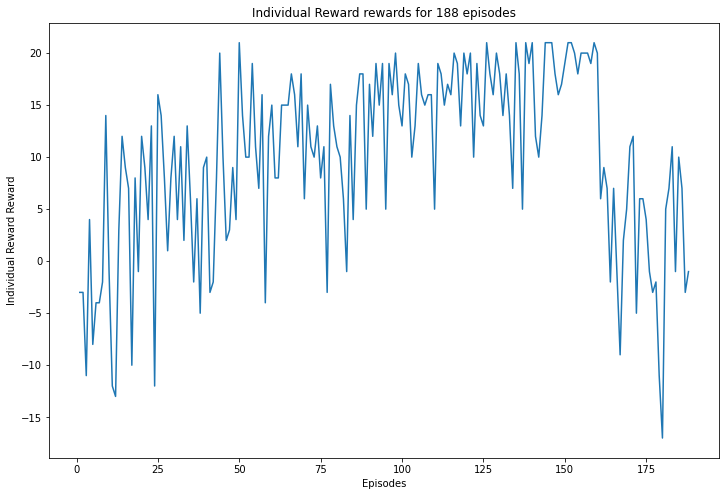

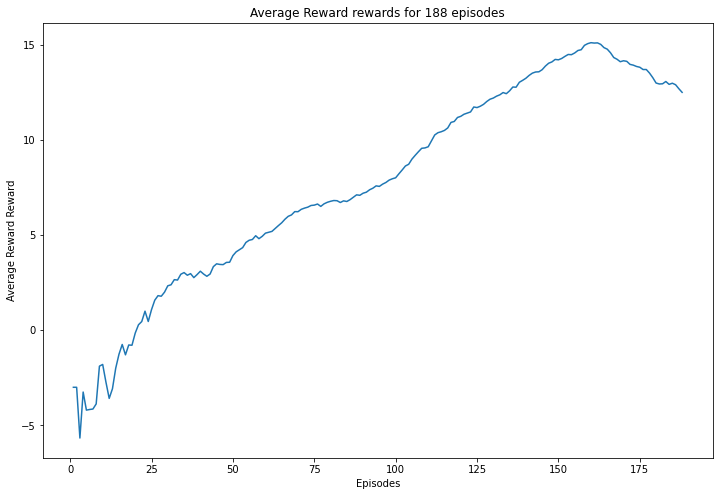

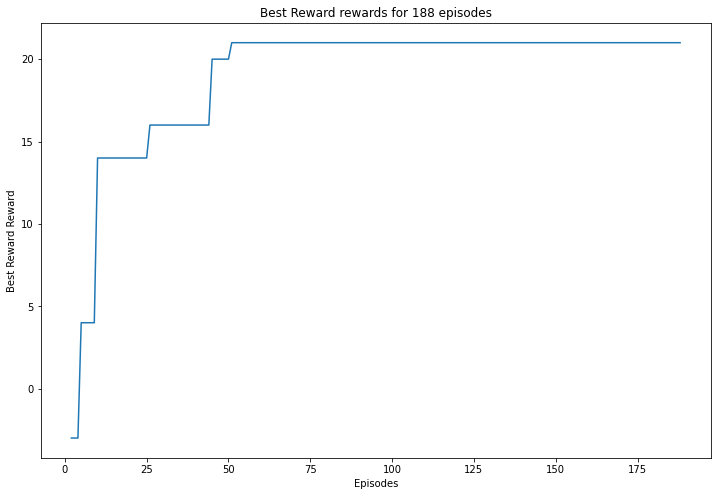

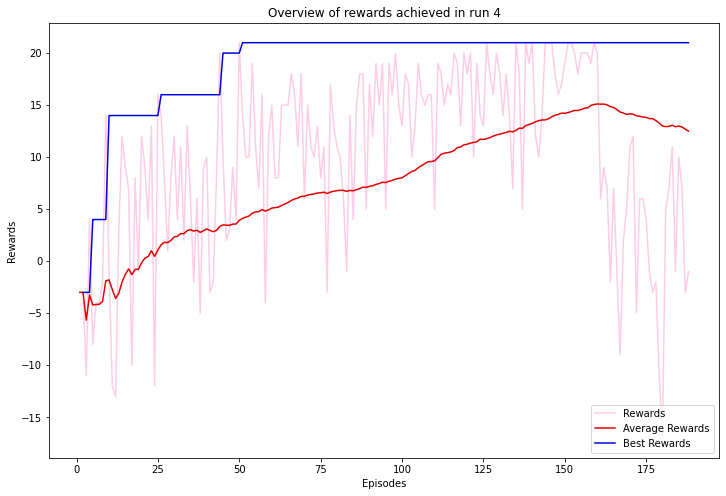

In [29]:
plot_rewards(re,188,"Individual Reward",4)
plot_rewards(ave_re,188,"Average Reward",4)
plot_rewards(best_re,188,"Best Reward",4)
pretty_plot(re,ave_re,best_re,4)

In [31]:
EPS_START = 0.1
EPS_FINL = 0.002 # try decay it slowly and have higher final epsilon and higher begining 
N_EPDS = 1500 
ave_re, re, best_re,ep = train(env,main_model,target_model,buffer,device,diff=2.5)
env.close()

  0%|          | 0/1500 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))



highest running_average_reward of -4.0 achieved!

EP 0, curr_reward: -4.0, best_reward: -4.0, running_avg_reward: -4.0, curr_epsilon: 0.1

This episode takes 1051 iterations

EP 1, curr_reward: -4.0, best_reward: -4.0, running_avg_reward: -4.0, curr_epsilon: 0.1
EP 2, curr_reward: -14.0, best_reward: -4.0, running_avg_reward: -7.333, curr_epsilon: 0.1
EP 3, curr_reward: -5.0, best_reward: -4.0, running_avg_reward: -6.75, curr_epsilon: 0.1

Learning starts!

EP 4, curr_reward: -11.0, best_reward: -4.0, running_avg_reward: -7.6, curr_epsilon: 0.0974
EP 5, curr_reward: -13.0, best_reward: -4.0, running_avg_reward: -8.5, curr_epsilon: 0.097
EP 6, curr_reward: -3.0, best_reward: -3.0, running_avg_reward: -7.714, curr_epsilon: 0.0965
EP 7, curr_reward: -5.0, best_reward: -3.0, running_avg_reward: -7.375, curr_epsilon: 0.0961
EP 8, curr_reward: 5.0, best_reward: 5.0, running_avg_reward: -6.0, curr_epsilon: 0.0955
EP 9, curr_reward: -4.0, best_reward: 5.0, running_avg_reward: -5.8, curr_epsil

KeyboardInterrupt: 

In [32]:
env.close()

In [57]:
EPS_START = 0.1
EPS_FINL = 0.002 # try decay it slowly and have higher final epsilon and higher begining 
N_EPDS = 1500 
ave_re, re, best_re,ep = train(env,main_model,target_model,buffer,device,diff=2.5)
env.close()

  0%|          | 0/1500 [00:00<?, ?it/s]


highest running_average_reward of -12.0 achieved!

EP 0, curr_reward: -12.0, best_reward: -12.0, running_avg_reward: -12.0, curr_epsilon: 0.1

This episode takes 1044 iterations


highest running_average_reward of -8.5 achieved!

EP 1, curr_reward: -5.0, best_reward: -5.0, running_avg_reward: -8.5, curr_epsilon: 0.1

highest running_average_reward of -6.333 achieved!

EP 2, curr_reward: -2.0, best_reward: -2.0, running_avg_reward: -6.333, curr_epsilon: 0.1

highest running_average_reward of -6.0 achieved!

EP 3, curr_reward: -5.0, best_reward: -2.0, running_avg_reward: -6.0, curr_epsilon: 0.1

Learning starts!


highest running_average_reward of -5.4 achieved!

EP 4, curr_reward: -3.0, best_reward: -2.0, running_avg_reward: -5.4, curr_epsilon: 0.0932

highest running_average_reward of -3.667 achieved!

EP 5, curr_reward: 5.0, best_reward: 5.0, running_avg_reward: -3.667, curr_epsilon: 0.0918
EP 6, curr_reward: -5.0, best_reward: 5.0, running_avg_reward: -3.857, curr_epsilon: 0.0905
EP


highest running_average_reward of 1.986 achieved!

EP 70, curr_reward: 12.0, best_reward: 18.0, running_avg_reward: 1.986, curr_epsilon: 0.0398

highest running_average_reward of 2.236 achieved!

EP 71, curr_reward: 20.0, best_reward: 20.0, running_avg_reward: 2.236, curr_epsilon: 0.0395
EP 72, curr_reward: -1.0, best_reward: 20.0, running_avg_reward: 2.192, curr_epsilon: 0.0389
EP 73, curr_reward: 3.0, best_reward: 20.0, running_avg_reward: 2.203, curr_epsilon: 0.0384

highest running_average_reward of 2.267 achieved!

EP 74, curr_reward: 7.0, best_reward: 20.0, running_avg_reward: 2.267, curr_epsilon: 0.0379

highest running_average_reward of 2.355 achieved!

EP 75, curr_reward: 9.0, best_reward: 20.0, running_avg_reward: 2.355, curr_epsilon: 0.0373

This episode takes 1124 iterations


highest running_average_reward of 2.558 achieved!

EP 76, curr_reward: 18.0, best_reward: 20.0, running_avg_reward: 2.558, curr_epsilon: 0.037

highest running_average_reward of 2.718 achieved!

EP 7

EP 128, curr_reward: 8.0, best_reward: 21.0, running_avg_reward: 10.67, curr_epsilon: 0.022

highest running_average_reward of 10.74 achieved!

EP 129, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 10.74, curr_epsilon: 0.0219

highest running_average_reward of 10.84 achieved!

EP 130, curr_reward: 9.0, best_reward: 21.0, running_avg_reward: 10.84, curr_epsilon: 0.0216

highest running_average_reward of 10.95 achieved!

EP 131, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 10.95, curr_epsilon: 0.0215

highest running_average_reward of 11.05 achieved!

EP 132, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 11.05, curr_epsilon: 0.0212

highest running_average_reward of 11.06 achieved!

EP 133, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 11.06, curr_epsilon: 0.021

highest running_average_reward of 11.36 achieved!

EP 134, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 11.36, curr_epsilon: 0.0209

highest running_average_reward of

EP 189, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 15.83, curr_epsilon: 0.0132

highest running_average_reward of 15.89 achieved!

EP 190, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 15.89, curr_epsilon: 0.0131
EP 191, curr_reward: 8.0, best_reward: 21.0, running_avg_reward: 15.77, curr_epsilon: 0.0129
EP 192, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 15.85, curr_epsilon: 0.0128

highest running_average_reward of 15.91 achieved!

EP 193, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 15.91, curr_epsilon: 0.0127

highest running_average_reward of 16.0 achieved!

EP 194, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 16.0, curr_epsilon: 0.0126

highest running_average_reward of 16.07 achieved!

EP 195, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 16.07, curr_epsilon: 0.0125

highest running_average_reward of 16.12 achieved!

EP 196, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 16.12, curr_epsilon

EP 256, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 17.64, curr_epsilon: 0.0081
EP 257, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 17.58, curr_epsilon: 0.008
EP 258, curr_reward: 15.0, best_reward: 21.0, running_avg_reward: 17.54, curr_epsilon: 0.008
EP 259, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 17.54, curr_epsilon: 0.0079
EP 260, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 17.57, curr_epsilon: 0.0079

highest running_average_reward of 17.71 achieved!

EP 261, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 17.71, curr_epsilon: 0.0078

highest running_average_reward of 17.76 achieved!

EP 262, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 17.76, curr_epsilon: 0.0078

highest running_average_reward of 17.77 achieved!

EP 263, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 17.77, curr_epsilon: 0.0077

highest running_average_reward of 17.8 achieved!

EP 264, curr_reward: 19.0, best_reward: 21.


highest running_average_reward of 18.92 achieved!

EP 325, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 18.92, curr_epsilon: 0.0054

This episode takes 608 iterations


highest running_average_reward of 19.04 achieved!

EP 326, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.04, curr_epsilon: 0.0054
EP 327, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.02, curr_epsilon: 0.0053
EP 328, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.04, curr_epsilon: 0.0053
EP 329, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.03, curr_epsilon: 0.0053

highest running_average_reward of 19.06 achieved!

EP 330, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.06, curr_epsilon: 0.0052
EP 331, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.05, curr_epsilon: 0.0052
EP 332, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.02, curr_epsilon: 0.0052
EP 333, curr_reward: 21.0, best_reward: 21.0, running_av

EP 400, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.38, curr_epsilon: 0.0038

This episode takes 625 iterations

EP 401, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.4, curr_epsilon: 0.0038
EP 402, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.42, curr_epsilon: 0.0038
EP 403, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.42, curr_epsilon: 0.0038
EP 404, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.45, curr_epsilon: 0.0038
EP 405, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.48, curr_epsilon: 0.0038
EP 406, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.46, curr_epsilon: 0.0037
EP 407, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.46, curr_epsilon: 0.0037
EP 408, curr_reward: 15.0, best_reward: 21.0, running_avg_reward: 19.4, curr_epsilon: 0.0037
EP 409, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.39, curr_epsilon: 0.0037
EP 410, curr_reward: 21.0,

EP 486, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.3, curr_epsilon: 0.0029
EP 487, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.3, curr_epsilon: 0.0029
EP 488, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.31, curr_epsilon: 0.0029
EP 489, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.38, curr_epsilon: 0.0029
EP 490, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 19.33, curr_epsilon: 0.0029
EP 491, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.32, curr_epsilon: 0.0029
EP 492, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.3, curr_epsilon: 0.0029
EP 493, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.27, curr_epsilon: 0.0028
EP 494, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.27, curr_epsilon: 0.0028
EP 495, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.28, curr_epsilon: 0.0028
EP 496, curr_reward: 21.0, best_reward: 21.0, running_avg_rewar


highest running_average_reward of 19.76 achieved!

EP 568, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.76, curr_epsilon: 0.0025

highest running_average_reward of 19.77 achieved!

EP 569, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.77, curr_epsilon: 0.0025

highest running_average_reward of 19.78 achieved!

EP 570, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.78, curr_epsilon: 0.0025
EP 571, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.78, curr_epsilon: 0.0024
EP 572, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.77, curr_epsilon: 0.0024
EP 573, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.76, curr_epsilon: 0.0024
EP 574, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.77, curr_epsilon: 0.0024

highest running_average_reward of 19.8 achieved!

EP 575, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.8, curr_epsilon: 0.0024

This episode takes 642 iterations

EP 576

EP 647, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.72, curr_epsilon: 0.0022
EP 648, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.69, curr_epsilon: 0.0022
EP 649, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.71, curr_epsilon: 0.0022
EP 650, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.69, curr_epsilon: 0.0022

This episode takes 633 iterations

EP 651, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 19.64, curr_epsilon: 0.0022
EP 652, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.61, curr_epsilon: 0.0022
EP 653, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.64, curr_epsilon: 0.0022
EP 654, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.64, curr_epsilon: 0.0022
EP 655, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.62, curr_epsilon: 0.0022
EP 656, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.65, curr_epsilon: 0.0022
EP 657, curr_reward: 21.

EP 733, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.75, curr_epsilon: 0.0021
EP 734, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.73, curr_epsilon: 0.0021
EP 735, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.75, curr_epsilon: 0.0021
EP 736, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.75, curr_epsilon: 0.0021
EP 737, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.77, curr_epsilon: 0.0021
EP 738, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.78, curr_epsilon: 0.0021
EP 739, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.78, curr_epsilon: 0.0021
EP 740, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.79, curr_epsilon: 0.0021
EP 741, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.81, curr_epsilon: 0.0021
EP 742, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.81, curr_epsilon: 0.0021
EP 743, curr_reward: 21.0, best_reward: 21.0, running_avg_re

EP 819, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.78, curr_epsilon: 0.0021
EP 820, curr_reward: 12.0, best_reward: 21.0, running_avg_reward: 19.69, curr_epsilon: 0.0021
EP 821, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.69, curr_epsilon: 0.0021
EP 822, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.69, curr_epsilon: 0.0021
EP 823, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.69, curr_epsilon: 0.0021
EP 824, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.71, curr_epsilon: 0.0021
EP 825, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.76, curr_epsilon: 0.0021

This episode takes 608 iterations

EP 826, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.78, curr_epsilon: 0.0021
EP 827, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.78, curr_epsilon: 0.0021
EP 828, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.78, curr_epsilon: 0.0021
EP 829, curr_reward: 19.

EP 906, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.94, curr_epsilon: 0.002
EP 907, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.94, curr_epsilon: 0.002
EP 908, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.93, curr_epsilon: 0.002
EP 909, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.93, curr_epsilon: 0.002
EP 910, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.91, curr_epsilon: 0.002
EP 911, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.96, curr_epsilon: 0.002
EP 912, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.96, curr_epsilon: 0.002

highest running_average_reward of 20.02 achieved!

EP 913, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.02, curr_epsilon: 0.002

highest running_average_reward of 20.05 achieved!

EP 914, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.05, curr_epsilon: 0.002
EP 915, curr_reward: 19.0, best_reward: 21.0, running_avg_r

EP 991, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.99, curr_epsilon: 0.002
EP 992, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 19.94, curr_epsilon: 0.002
EP 993, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.94, curr_epsilon: 0.002
EP 994, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.91, curr_epsilon: 0.002
EP 995, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.91, curr_epsilon: 0.002
EP 996, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.9, curr_epsilon: 0.002
EP 997, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.9, curr_epsilon: 0.002
EP 998, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.89, curr_epsilon: 0.002
EP 999, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.89, curr_epsilon: 0.002
EP 1000, curr_reward: 16.0, best_reward: 21.0, running_avg_reward: 19.85, curr_epsilon: 0.002

This episode takes 728 iterations

EP 1001, curr_reward: 19.0, best_re

EP 1077, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.55, curr_epsilon: 0.002
EP 1078, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.57, curr_epsilon: 0.002
EP 1079, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.58, curr_epsilon: 0.002
EP 1080, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 1081, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 1082, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.61, curr_epsilon: 0.002
EP 1083, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.6, curr_epsilon: 0.002
EP 1084, curr_reward: 18.0, best_reward: 21.0, running_avg_reward: 19.62, curr_epsilon: 0.002
EP 1085, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.62, curr_epsilon: 0.002
EP 1086, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.58, curr_epsilon: 0.002
EP 1087, curr_reward: 20.0, best_reward: 21.0, running_avg_re

EP 1164, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 1165, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.62, curr_epsilon: 0.002
EP 1166, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.62, curr_epsilon: 0.002
EP 1167, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 1168, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.65, curr_epsilon: 0.002
EP 1169, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.66, curr_epsilon: 0.002
EP 1170, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.64, curr_epsilon: 0.002
EP 1171, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.63, curr_epsilon: 0.002
EP 1172, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.64, curr_epsilon: 0.002
EP 1173, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.64, curr_epsilon: 0.002
EP 1174, curr_reward: 17.0, best_reward: 21.0, running_avg_r

EP 1248, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 20.17, curr_epsilon: 0.002
EP 1249, curr_reward: 14.0, best_reward: 21.0, running_avg_reward: 20.1, curr_epsilon: 0.002
EP 1250, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.11, curr_epsilon: 0.002

This episode takes 559 iterations

EP 1251, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 20.08, curr_epsilon: 0.002
EP 1252, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 20.04, curr_epsilon: 0.002
EP 1253, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 20.03, curr_epsilon: 0.002
EP 1254, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.04, curr_epsilon: 0.002
EP 1255, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 20.04, curr_epsilon: 0.002
EP 1256, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.06, curr_epsilon: 0.002
EP 1257, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.06, curr_epsilon: 0.002
EP 1258, curr_reward: 19.

EP 1334, curr_reward: 17.0, best_reward: 21.0, running_avg_reward: 19.87, curr_epsilon: 0.002
EP 1335, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.87, curr_epsilon: 0.002
EP 1336, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.87, curr_epsilon: 0.002
EP 1337, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.86, curr_epsilon: 0.002
EP 1338, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 19.85, curr_epsilon: 0.002
EP 1339, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 19.86, curr_epsilon: 0.002
EP 1340, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.86, curr_epsilon: 0.002
EP 1341, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.86, curr_epsilon: 0.002
EP 1342, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.86, curr_epsilon: 0.002
EP 1343, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 19.88, curr_epsilon: 0.002
EP 1344, curr_reward: 20.0, best_reward: 21.0, running_avg_r

EP 1422, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.11, curr_epsilon: 0
EP 1423, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.11, curr_epsilon: 0
EP 1424, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.11, curr_epsilon: 0
EP 1425, curr_reward: 20.0, best_reward: 21.0, running_avg_reward: 20.11, curr_epsilon: 0

This episode takes 640 iterations

EP 1426, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 20.11, curr_epsilon: 0
EP 1427, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.15, curr_epsilon: 0
EP 1428, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.22, curr_epsilon: 0
EP 1429, curr_reward: 19.0, best_reward: 21.0, running_avg_reward: 20.2, curr_epsilon: 0
EP 1430, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.2, curr_epsilon: 0
EP 1431, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 20.2, curr_epsilon: 0
EP 1432, curr_reward: 21.0, best_reward: 21.0, running_avg_reward: 

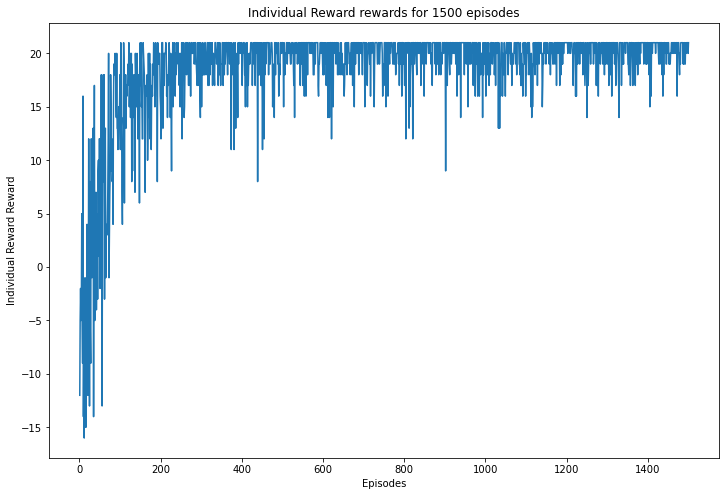

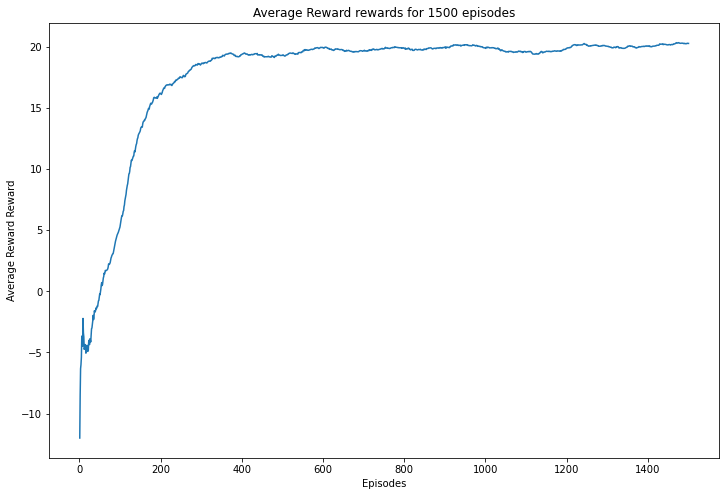

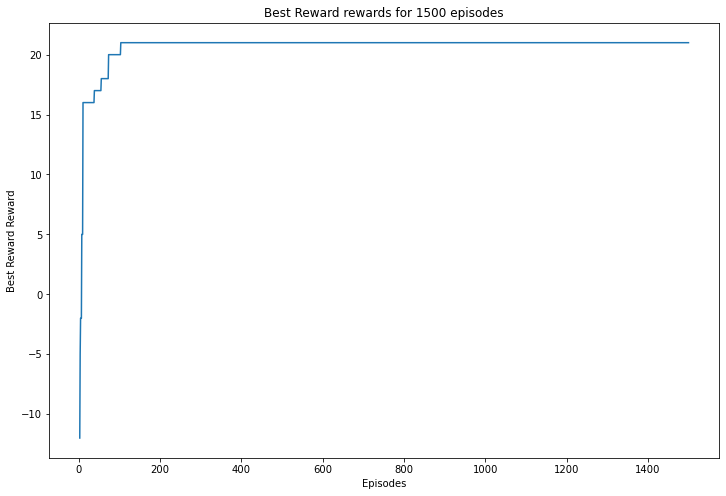

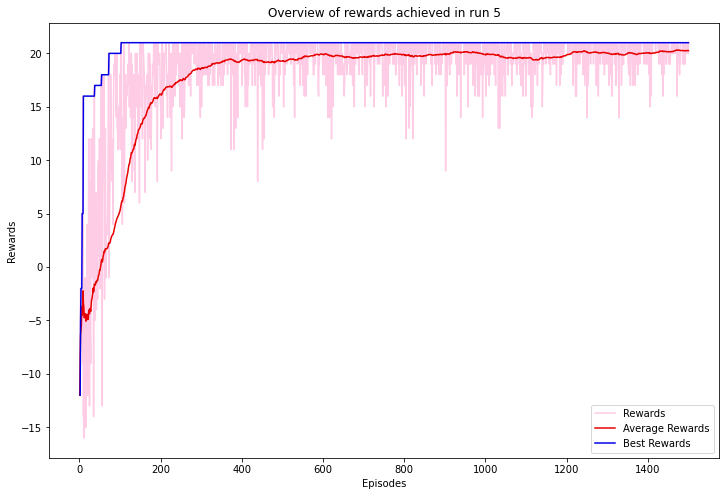

In [58]:
plot_rewards(re,1500,"Individual Reward",5)
plot_rewards(ave_re,1500,"Average Reward",5)
plot_rewards(best_re,1500,"Best Reward",5)
pretty_plot(re,ave_re,best_re,5)

## Comparison

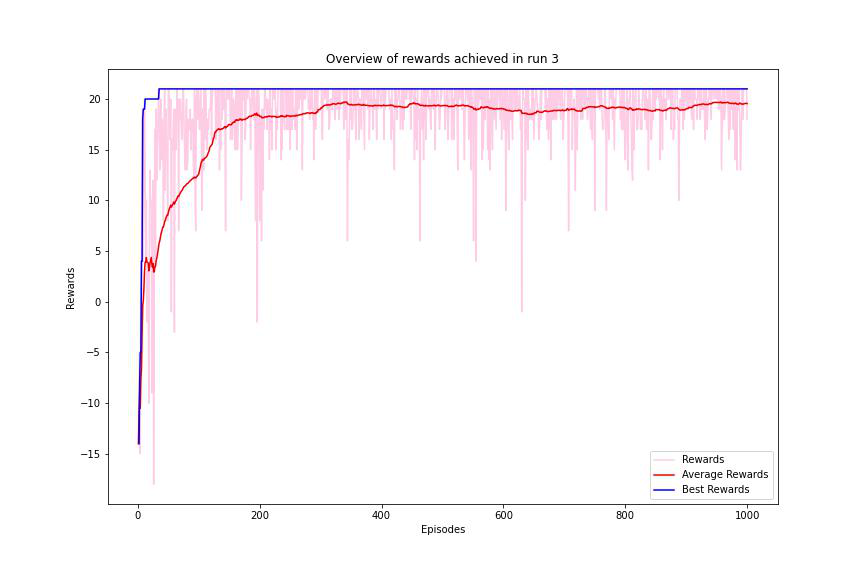

In [74]:
# run 3
PIL.Image.open("PrettyFig/run_3.jpg")


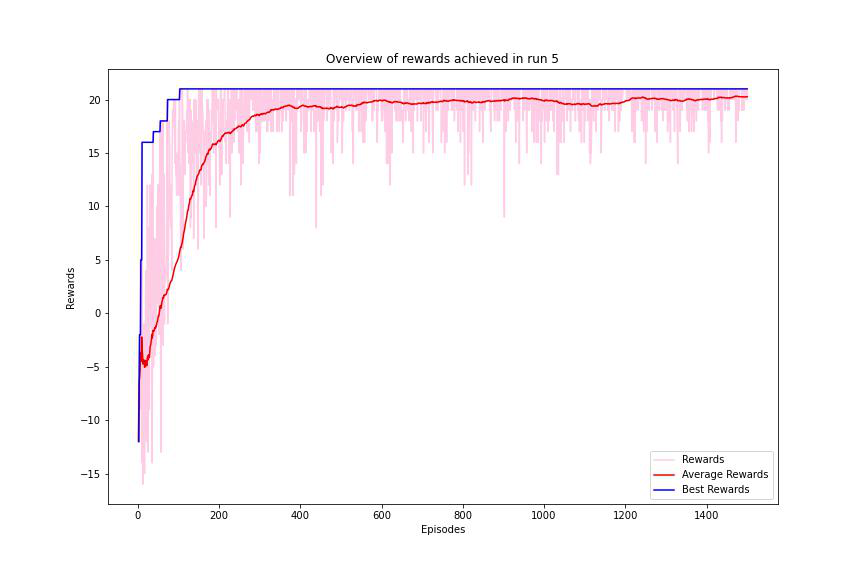

In [73]:
PIL.Image.open("PrettyFig/run_5.jpg")